## Contents
-  [1.Importing Libraries](#1)
-  [2.Dataset Management](#2)
    -  [2.1.Downloading and Extracting Dataset](#2.1)
    -  [2.2.Visualizing Dataset](#2.2)
    -  [2.3.Splitting Dataset](#2.3)
    -  [2.4.Pytorch DataLoaders](#2.4)
-  [3.Initializing pre-trained model](#3)
-  [4.Training](#4)
-  [5.Plotting Results](#5)
    -  [5.1.Plotting Loss vs MiniBatch](#5.1)
    -  [5.2.Plotting Accuracy vs MiniBatch](#5.2)
    -  [5.3.Plotting Loss vs Epoch](#5.3)
    -  [5.4.Plotting Accuracy vs Epoch](#5.4)
    -  [5.5.Plotting F1 Score vs Epoch](#5.5)
    -  [5.6.Plotting Recall vs Epoch](#5.6)
    -  [5.7.Plotting Precision vs Epoch](#5.7)
    -  [5.8.Plotting Kappa vs Epoch](#5.8)
-  [6.Testing](#6)

### 1.Importing Libraries <a class="anchor" id="1"></a>

In [1]:
!pip install timm
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 1.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
from sklearn import cluster
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import os
import random
import pickle

torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (10,10)


### 2.Dataset Managament <a class="anchor" id="2"></a>

#### 1.Downloading and Extracting Dataset <a class="anchor" id="2.1"></a>

In [3]:
import pandas as pd

test_raw = pd.read_csv("/kaggle/input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv")
train_raw = pd.read_csv("/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv")
train_raw.head()



,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [4]:
path = '/kaggle/input/game-of-deep-learning-ship-datasets/train/images/'

test_img = []

img = []
label = []

for index, row in train_raw.iterrows():
    img.append(path+row['image'])
    label.append(row['category']-1)
    
for index, row in test_raw.iterrows():
    test_img.append(path+row['image'])

#### 2.Visualizing Dataset <a class="anchor" id="2.2"></a>

In [5]:
print(len(test_img), len(img))

2680 6252


In [6]:
from collections import Counter
Counter(label)

Counter({0: 2120, 1: 1167, 2: 916, 3: 832, 4: 1217})

#### 3.Splitting Dataset <a class="anchor" id="2.3"></a>

In [7]:
x = [0, 0, 0, 0, 0]
i=0

val_img = []
val_label = []

while (x!=[15, 15, 15, 15, 15]):
    l = label[i]
    if x[l]!=15:
        val_img.append(img[i])
        val_label.append(l)
        del label[i], img[i]
        x[l]+=1
        continue
        
    i+=1        

In [8]:
Counter(val_label)

Counter({0: 15, 1: 15, 2: 15, 3: 15, 4: 15})

In [9]:
import gc

gc.collect()

42

#### 4.Pytorch DataLoaders <a class="anchor" id="2.4"></a>

In [10]:
# import cv2
from PIL import Image

class Dataset(Dataset):
    def __init__(self,x,y,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.y = y 
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        img = Image.open(self.x[i]).convert('RGB')
        return torch.FloatTensor(np.asarray(self.transform(img))),torch.LongTensor([self.y[i]])

class TestDataset(Dataset):
    def __init__(self,x,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        img = Image.open(self.x[i]).convert('RGB')
        return torch.FloatTensor(np.asarray(self.transform(img)))
    

batch_size = 16

transforms_train = T.Compose([
        T.Resize((224,224)),
#         T.RandomRotation(degrees=(-45, 45)),
#         T.RandomHorizontalFlip(),
#         T.RandomVerticalFlip(),
        T.ToTensor(),
#         T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_test = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
#         T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = Dataset(img, label,transform =transforms_train)
validation_dataset = Dataset(val_img, val_label,transform =transforms_test)
test_dataset = TestDataset(test_img,transform =transforms_test)

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True )
validation_dataloader = DataLoader(validation_dataset , batch_size = batch_size , shuffle = True )
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = False )

In [11]:
next(iter(test_dataloader))

tensor([[[[0.9725, 0.9725, 0.9608,  ..., 0.8745, 0.8314, 0.8549],
          [0.9725, 0.9725, 0.9608,  ..., 0.8745, 0.8314, 0.8549],
          [0.9686, 0.9686, 0.9647,  ..., 0.8471, 0.8275, 0.8549],
          ...,
          [0.4627, 0.4196, 0.4078,  ..., 0.3255, 0.3922, 0.4824],
          [0.4824, 0.4392, 0.4196,  ..., 0.3529, 0.4314, 0.5098],
          [0.4824, 0.4392, 0.4196,  ..., 0.3529, 0.4314, 0.5098]],

         [[0.9647, 0.9647, 0.9608,  ..., 0.8863, 0.8510, 0.8745],
          [0.9647, 0.9647, 0.9608,  ..., 0.8863, 0.8510, 0.8745],
          [0.9608, 0.9647, 0.9647,  ..., 0.8627, 0.8471, 0.8745],
          ...,
          [0.4118, 0.3765, 0.3647,  ..., 0.2941, 0.3412, 0.4275],
          [0.4314, 0.3961, 0.3765,  ..., 0.3176, 0.3765, 0.4510],
          [0.4314, 0.3961, 0.3765,  ..., 0.3176, 0.3765, 0.4510]],

         [[0.9765, 0.9765, 0.9647,  ..., 0.9137, 0.8627, 0.8863],
          [0.9765, 0.9765, 0.9647,  ..., 0.9137, 0.8627, 0.8863],
          [0.9725, 0.9765, 0.9686,  ..., 0

### 3.Initializing pre-trained model <a class="anchor" id="3"></a>

In [12]:
model_name = "vit_base_patch8_224"
class ViTBase16(nn.Module):
    def __init__(self, n_classes):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model(model_name, pretrained=True)
        
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


model = ViTBase16(5)
for param in model.parameters():
    param.requires_grad = True

### 4.Training <a class="anchor" id="4"></a>

In [13]:
lr = 0.0015
epoch = 30
train_dataset_size = train_dataset.__len__()
validation_dataset_size = validation_dataset.__len__()
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()

device = 'cuda'
model.to(device)
loss_history = [[],[]] #[[train], [validation]]
accuracy_history = [[],[]] #[[train], [validation]]
# prec_history = [[],[]] #[[train], [validation]]
# recall_history = [[],[]] #[[train], [validation]]
# f1_history = [[],[]] #[[train], [validation]]
# support_history = [[],[]] #[[train], [validation]]

results = [[],[]]
kappa = [[],[]]

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(),lr = lr)



In [14]:
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score


for e in range(epoch):
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    y_all_train_true = []
    y_all_train_pred = []
    y_all_val_true = []
    y_all_val_pred = []
    
    for batch_idx , (x ,y) in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y = x.to(device) , y.to(device)
        y_pred = model(x).to(device)
        
        y_all_train_true+=y.cpu().detach().view(-1,).tolist()
        y_all_train_pred+=torch.argmax(y_pred, dim=1).detach().tolist()
        
        # Calculating Loss
        loss = criterion(y_pred,y.reshape(x.shape[0]))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        for i in range(x.shape[0]):
            n = 0
            n = y_pred[i].index(max(y_pred[i]))
            if n == y[i][0]:
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)
        
        if batch_idx % (len(train_dataloader)//2) == 0:
            # Printing Log
            print(f'LOSS for EPOCH {e+1} BATCH {batch_idx}/{train_n_minibatches} TRAIN LOSS : {loss_history[0][-1]}',end = ' ')
            print(f'TRAIN ACCURACY : {accuracy_history[0][-1]}',end = ' ')
            with torch.no_grad():
                # Calculating loss and accuracy for validation
                model.eval()
                for _batch_idx_ , (x ,y) in enumerate(validation_dataloader):
                    x , y = x.to(device) , y.to(device)
                    y_pred = model(x).to(device)
                    
                    y_all_val_true+=y.cpu().detach().view(-1,).tolist()
                    y_all_val_pred+=torch.argmax(y_pred, dim=1).detach().tolist()
                    
                    validation_loss = criterion(y_pred,y.reshape(x.shape[0]))
                    loss_history[1].append(float(validation_loss.detach()))
                    
                    correct = 0
                    y_pred = y_pred.cpu().detach().numpy().tolist()
                    y = y.cpu().detach().numpy().tolist()      
                    for i in range(x.shape[0]):
                        n = 0
                        n = y_pred[i].index(max(y_pred[i]))
                        if n == y[i][0]:
                            correct = correct + 1
                    accuracy_history[1].append((correct/x.shape[0])*100)
                        
                    
                print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
                print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}')
    
    # Saving the model progress
    torch.save(model.state_dict(),model_name)
    
    results[0].append(precision_recall_fscore_support(y_all_train_true,y_all_train_pred))
    results[1].append(precision_recall_fscore_support(y_all_val_true,y_all_val_pred))

    kappa[0].append(cohen_kappa_score(y_all_train_true,y_all_train_pred))
    kappa[1].append(cohen_kappa_score(y_all_val_true,y_all_val_pred))
    
    #Log for e+1th epoch
    print(f'--------------------------------------------------------------------------------------------')
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    print(f'TRAIN PREC : {results[0][-1][0]} RECALL : {results[0][-1][1]} F1 : {results[0][-1][2]}',end=" ")
    print(f'ACC : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}', end=" ")
    print(f' KAPPA : {sum(kappa[0][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}')
    print(f'VALIDATION LOSS for EPOCH {e+1} : {sum(loss_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
    print(f'VALIDATION PREC : {results[1][-1][0]} RECALL : {results[1][-1][1]} F1 : {results[1][-1][2]}',end=" ")
    print(f' ACC : {sum(accuracy_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}',end=" ")
    print(f' KAPPA : {sum(kappa[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}')
    print('---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 BATCH 0/387 TRAIN LOSS : 2.529416799545288 TRAIN ACCURACY : 18.75 VALIDATION LOSS : 13.270319175720214 VALIDATION ACCURACY : 18.75
LOSS for EPOCH 1 BATCH 193/387 TRAIN LOSS : 1.8388280868530273 TRAIN ACCURACY : 25.0 VALIDATION LOSS : 1.778352403640747 VALIDATION ACCURACY : 21.59090909090909
LOSS for EPOCH 1 BATCH 386/387 TRAIN LOSS : 2.0458154678344727 TRAIN ACCURACY : 0.0 VALIDATION LOSS : 1.5023991584777832 VALIDATION ACCURACY : 28.75


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------
Loss for EPOCH 1  TRAIN LOSS : 1.825223154183814 TRAIN PREC : [0.36506599 0.28628709 0.14328358 0.14749263 0.23741007] RECALL : [0.6175772  0.30989583 0.05327414 0.06119951 0.13727121] F1 : [0.45887752 0.29762401 0.0776699  0.08650519 0.17395888] ACC : 31.007751937984494  KAPPA : 0.01088294983453375
VALIDATION LOSS for EPOCH 1 : 1.5023991584777832 VALIDATION PREC : [0.21296296 0.33333333 0.         0.         0.22619048] RECALL : [0.51111111 0.24444444 0.         0.         0.42222222] F1 : [0.30065359 0.28205128 0.         0.         0.29457364]  ACC : 28.75  KAPPA : 0.00888888888888888
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 2-------------------------------------------
LOSS for EPOCH 2 BATCH 0/387 TRAIN LOSS : 1.3759549856185913 TRAIN ACCURACY : 43.75 VALIDATION LOSS : 1.5047958612442016 VALIDAT

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------
Loss for EPOCH 2  TRAIN LOSS : 1.374623895461553 TRAIN PREC : [0.42699178 0.44476744 0.27567568 0.21875    0.39923225] RECALL : [0.71543943 0.6640625  0.05660377 0.05997552 0.17304493] F1 : [0.53480114 0.53272981 0.09392265 0.09414025 0.24143935] ACC : 41.89276485788114  KAPPA : 0.050840097658877405
VALIDATION LOSS for EPOCH 2 : 1.5307304620742799 VALIDATION PREC : [0.23636364 0.36904762 0.         0.         0.4516129 ] RECALL : [0.57777778 0.68888889 0.         0.         0.31111111] F1 : [0.33548387 0.48062016 0.         0.         0.36842105]  ACC : 36.590909090909086  KAPPA : 0.03777777777777778
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 3-------------------------------------------
LOSS for EPOCH 3 BATCH 0/387 TRAIN LOSS : 1.7454522848129272 TRAIN ACCURACY : 18.75 VALIDATION LOSS : 1.54590141773

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------
Loss for EPOCH 3  TRAIN LOSS : 1.3279704428458399 TRAIN PREC : [0.43319954 0.48510638 0.32608696 0.25       0.40909091] RECALL : [0.71781473 0.69270833 0.08324084 0.06731946 0.20216306] F1 : [0.54031825 0.57061137 0.13262599 0.10607522 0.27060134] ACC : 43.31395348837209  KAPPA : 0.09562174646608013
VALIDATION LOSS for EPOCH 3 : 1.4639936685562134 VALIDATION PREC : [0.18055556 0.37078652 0.         0.33333333 0.40983607] RECALL : [0.28888889 0.73333333 0.         0.02222222 0.55555556] F1 : [0.22222222 0.49253731 0.         0.04166667 0.47169811]  ACC : 32.27272727272727  KAPPA : 0.06777777777777778
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 4-------------------------------------------
LOSS for EPOCH 4 BATCH 0/387 TRAIN LOSS : 1.5491242408752441 TRAIN ACCURACY : 37.5 VALIDATION LOSS : 1.4435834407806

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------
Loss for EPOCH 4  TRAIN LOSS : 1.314079151751151 TRAIN PREC : [0.44186712 0.48102017 0.3655914  0.2907489  0.41808874] RECALL : [0.73301663 0.70399306 0.0754717  0.08078335 0.20382696] F1 : [0.5513668  0.57152925 0.125115   0.12643678 0.27404922] ACC : 44.1375968992248  KAPPA : 0.14260176227619759
VALIDATION LOSS for EPOCH 4 : 1.3624897003173828 VALIDATION PREC : [0.24271845 0.36263736 0.         0.33333333 0.39285714] RECALL : [0.55555556 0.73333333 0.         0.02222222 0.24444444] F1 : [0.33783784 0.48529412 0.         0.04166667 0.30136986]  ACC : 29.886363636363637  KAPPA : 0.09555555555555555
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 5-------------------------------------------
LOSS for EPOCH 5 BATCH 0/387 TRAIN LOSS : 1.1843031644821167 TRAIN ACCURACY : 50.0 VALIDATION LOSS : 1.35941982269287

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------
Loss for EPOCH 7  TRAIN LOSS : 1.2873624997545583 TRAIN PREC : [0.44975384 0.49970042 0.41569767 0.27411168 0.43968872] RECALL : [0.73776722 0.72395833 0.15871254 0.06609547 0.18801997] F1 : [0.55883411 0.59127969 0.22971888 0.10650888 0.26340326] ACC : 45.38113695090439  KAPPA : 0.2355681343460975
VALIDATION LOSS for EPOCH 7 : 1.3658936023712158 VALIDATION PREC : [0.29457364 0.38888889 0.57142857 0.         0.7       ] RECALL : [0.84444444 0.62222222 0.17777778 0.         0.15555556] F1 : [0.43678161 0.47863248 0.27118644 0.         0.25454545]  ACC : 36.13636363636364  KAPPA : 0.16666666666666666
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 8-------------------------------------------
LOSS for EPOCH 8 BATCH 0/387 TRAIN LOSS : 1.3369601964950562 TRAIN ACCURACY : 50.0 VALIDATION LOSS : 1.36050577163696

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------
Loss for EPOCH 10  TRAIN LOSS : 1.2794436373451883 TRAIN PREC : [0.45459923 0.49671249 0.40616246 0.28632479 0.47368421] RECALL : [0.73016627 0.72135417 0.1609323  0.08200734 0.20965058] F1 : [0.5603354  0.58831858 0.23052464 0.12749762 0.29065744] ACC : 45.97868217054263  KAPPA : 0.24859290875753456
VALIDATION LOSS for EPOCH 10 : 1.245859479904175 VALIDATION PREC : [0.28947368 0.37209302 0.55555556 0.         0.6875    ] RECALL : [0.73333333 0.71111111 0.11111111 0.         0.24444444] F1 : [0.41509434 0.48854962 0.18518519 0.         0.36065574]  ACC : 41.02272727272727  KAPPA : 0.22444444444444445
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 11-------------------------------------------
LOSS for EPOCH 11 BATCH 0/387 TRAIN LOSS : 1.1713825464248657 TRAIN ACCURACY : 50.0 VALIDATION LOSS : 1.2689538002

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------
Loss for EPOCH 11  TRAIN LOSS : 1.2857988339677953 TRAIN PREC : [0.45888355 0.48366394 0.44893112 0.33173077 0.48007968] RECALL : [0.7263658  0.71961806 0.20976693 0.08445532 0.20049917] F1 : [0.56244252 0.57850663 0.28593041 0.13463415 0.28286385] ACC : 46.14018087855297  KAPPA : 0.2542579306662896
VALIDATION LOSS for EPOCH 11 : 1.3542989015579223 VALIDATION PREC : [0.3        0.37804878 0.68421053 0.         0.52941176] RECALL : [0.6        0.68888889 0.28888889 0.         0.4       ] F1 : [0.4        0.48818898 0.40625    0.         0.4556962 ]  ACC : 34.77272727272727  KAPPA : 0.22888888888888886
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 12-------------------------------------------
LOSS for EPOCH 12 BATCH 0/387 TRAIN LOSS : 1.2670295238494873 TRAIN ACCURACY : 31.25 VALIDATION LOSS : 1.339844226

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------
Loss for EPOCH 14  TRAIN LOSS : 1.2607327650375761 TRAIN PREC : [0.45711733 0.52262588 0.43160377 0.37541528 0.44761905] RECALL : [0.72921615 0.71180556 0.20310766 0.13831089 0.19550749] F1 : [0.56196229 0.60271959 0.27622642 0.20214669 0.27214823] ACC : 46.85077519379845  KAPPA : 0.26080597175759124
VALIDATION LOSS for EPOCH 14 : 1.4959885120391845 VALIDATION PREC : [0.25984252 0.36986301 0.4        0.         0.5       ] RECALL : [0.73333333 0.6        0.04444444 0.         0.22222222] F1 : [0.38372093 0.45762712 0.08       0.         0.30769231]  ACC : 27.95454545454545  KAPPA : 0.17999999999999997
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 15-------------------------------------------
LOSS for EPOCH 15 BATCH 0/387 TRAIN LOSS : 1.2753174304962158 TRAIN ACCURACY : 31.25 VALIDATION LOSS : 1.45618495

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------
Loss for EPOCH 17  TRAIN LOSS : 1.2587488276705878 TRAIN PREC : [0.45825771 0.50345261 0.44989339 0.32894737 0.47524752] RECALL : [0.71971496 0.69618056 0.23418424 0.12239902 0.19966722] F1 : [0.55997043 0.58433515 0.3080292  0.17841213 0.28119508] ACC : 46.31782945736434  KAPPA : 0.26904890077635746
VALIDATION LOSS for EPOCH 17 : 1.4032245874404907 VALIDATION PREC : [0.25961538 0.35820896 0.6        0.         0.51020408] RECALL : [0.6        0.53333333 0.06666667 0.         0.55555556] F1 : [0.36241611 0.42857143 0.12       0.         0.53191489]  ACC : 37.27272727272727  KAPPA : 0.17555555555555555
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 18-------------------------------------------
LOSS for EPOCH 18 BATCH 0/387 TRAIN LOSS : 1.1284093856811523 TRAIN ACCURACY : 43.75 VALIDATION LOSS : 1.37665989

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------
Loss for EPOCH 25  TRAIN LOSS : 1.268423048716799 TRAIN PREC : [0.46497585 0.50222505 0.41087613 0.35449735 0.51286449] RECALL : [0.73159145 0.68576389 0.1509434  0.16401469 0.24875208] F1 : [0.5685804  0.57981651 0.22077922 0.22426778 0.33501401] ACC : 46.81847545219638  KAPPA : 0.28555446530107587
VALIDATION LOSS for EPOCH 25 : 1.3578453302383422 VALIDATION PREC : [0.27559055 0.40740741 0.         0.46875    0.5       ] RECALL : [0.77777778 0.48888889 0.         0.33333333 0.13333333] F1 : [0.40697674 0.44444444 0.         0.38961039 0.21052632]  ACC : 35.340909090909086  KAPPA : 0.20888888888888885
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 26-------------------------------------------
LOSS for EPOCH 26 BATCH 0/387 TRAIN LOSS : 1.1158809661865234 TRAIN ACCURACY : 50.0 VALIDATION LOSS : 1.359675598

### 5.Plotting results <a class="anchor" id="4"></a>

#### 1.Plotting Loss vs MiniBatch<a class="anchor" id="5.1"></a>

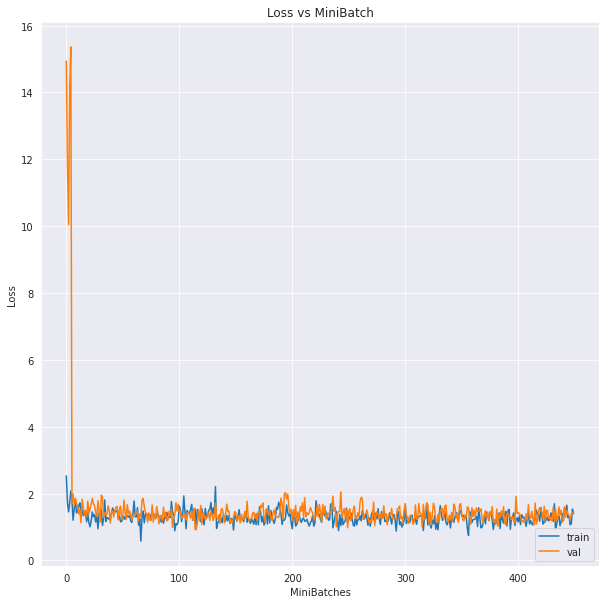

In [15]:
sns.lineplot(x=range(len(loss_history[1])),y=loss_history[0][::len(loss_history[0])//len(loss_history[1])][:len(loss_history[1])])
sns.lineplot(x=range(len(loss_history[1])),y=loss_history[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Loss vs MiniBatch")
plt.xlabel('MiniBatches')
plt.ylabel('Loss')


plt.show()


#### 2.Plotting Accuracy vs MiniBatch<a class="anchor" id="5.2"></a>

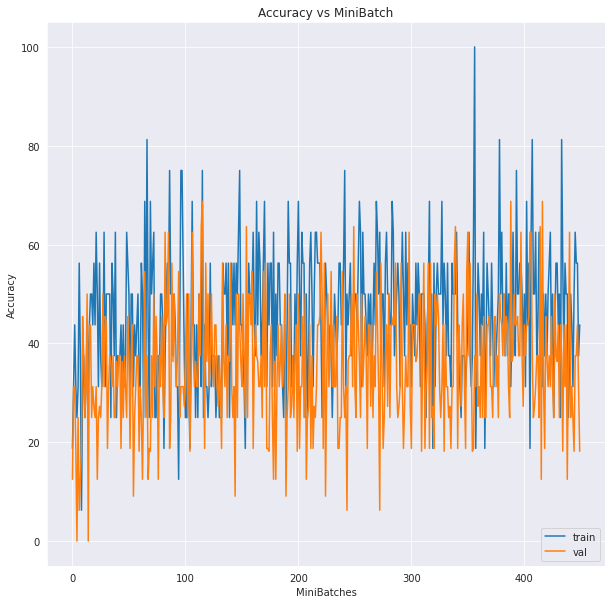

In [16]:
sns.lineplot(x=range(len(accuracy_history[1])),y=accuracy_history[0][::len(accuracy_history[0])//len(accuracy_history[1])][:len(accuracy_history[1])])
sns.lineplot(x=range(len(accuracy_history[1])),y=accuracy_history[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Accuracy vs MiniBatch")
plt.xlabel('MiniBatches')
plt.ylabel('Accuracy')

plt.show()


#### 3.Plotting Loss vs Epoch<a class="anchor" id="5.3"></a>

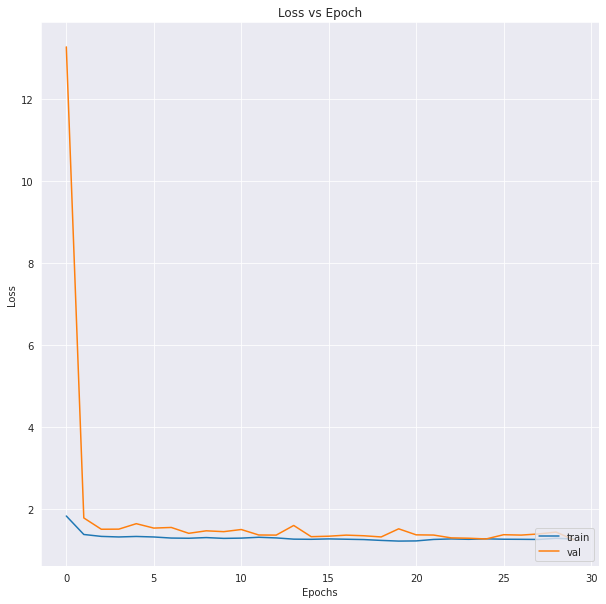

In [17]:
# Plotting Loss per epoch
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*validation_n_minibatches:(i+1)*validation_n_minibatches]:
        temp = temp + j
    loss_per_epoch[1].append(temp/validation_n_minibatches)    

sns.lineplot(x=range(len(loss_per_epoch[0])),y=loss_per_epoch[0])
sns.lineplot(x=range(len(loss_per_epoch[1])),y=loss_per_epoch[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Loss vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.show()

#### 4.Plotting Accuracy vs Epoch<a class="anchor" id="5.4"></a>

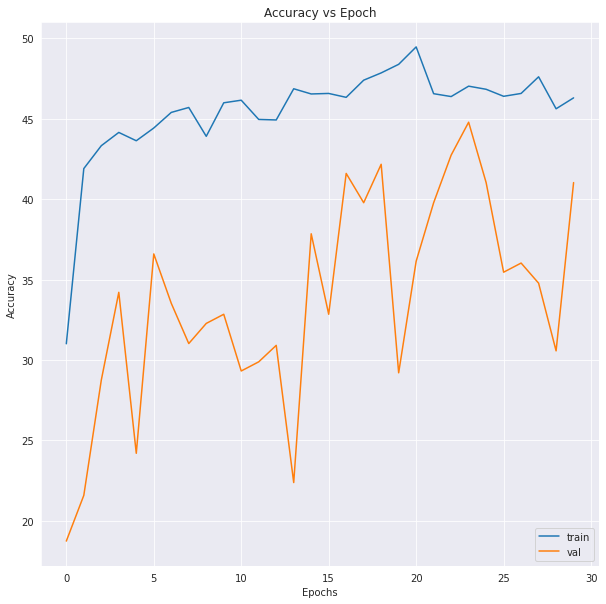

In [18]:
# Plotting Accuracy per epoch
accuracy_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in accuracy_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in accuracy_history[1][i*validation_n_minibatches:(i+1)*validation_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[1].append(temp/validation_n_minibatches)    

sns.lineplot(x=range(len(accuracy_per_epoch[0])),y=accuracy_per_epoch[0])
sns.lineplot(x=range(len(accuracy_per_epoch[1])),y=accuracy_per_epoch[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Accuracy vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

#### 5.Plotting F1Score vs Epoch<a class="anchor" id="5.5"></a>

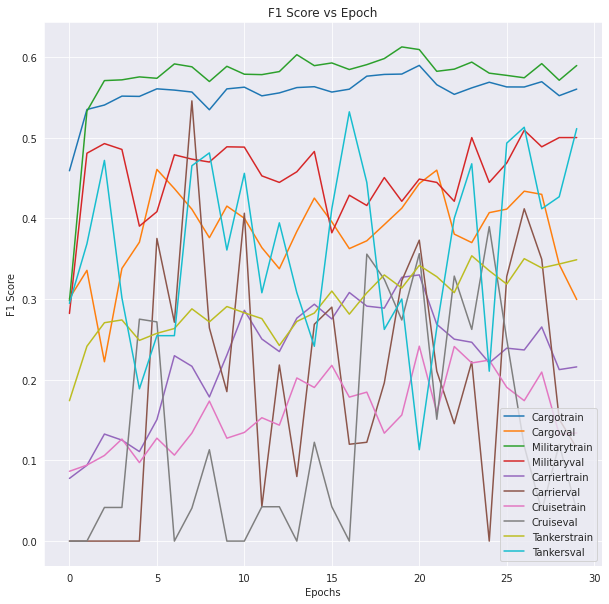

In [19]:
labels = {0:'Cargo',
1:'Military',
2:'Carrier',
3:'Cruise',
4:'Tankers'}

legend = []



for j in range(5):
    sns.lineplot(x=range(len(results[0])),y=[results[0][i][2][j] for i in range(len(results[0]))])
    sns.lineplot(x=range(len(results[1])),y=[results[1][i][2][j] for i in range(len(results[1]))])
    legend+=[labels[j]+'train', labels[j]+'val']



plt.legend(loc='lower right', labels=legend)
plt.title("F1 Score vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('F1 Score')


plt.show()

#### 6.Plotting Recall vs Epoch<a class="anchor" id="5.6"></a>

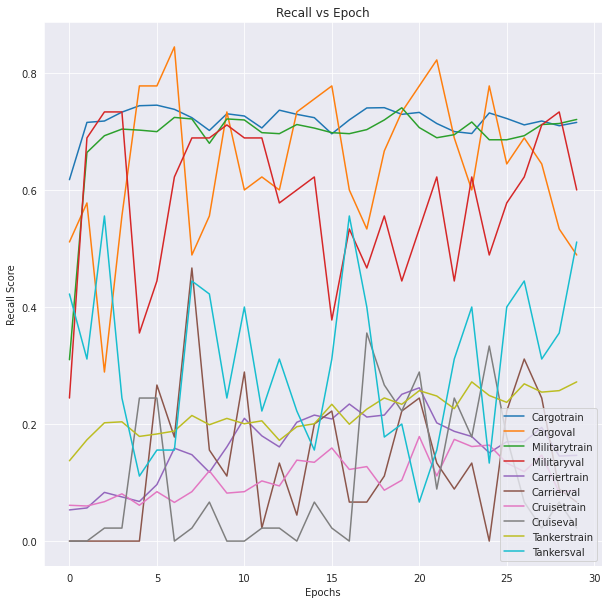

In [20]:
for j in range(5):
    sns.lineplot(x=range(len(results[0])),y=[results[0][i][1][j] for i in range(len(results[0]))])
    sns.lineplot(x=range(len(results[1])),y=[results[1][i][1][j] for i in range(len(results[1]))])


plt.legend(loc='lower right', labels=legend)
plt.title("Recall vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Recall Score')


plt.show()

#### 7.Plotting Precision vs Epoch<a class="anchor" id="5.7"></a>

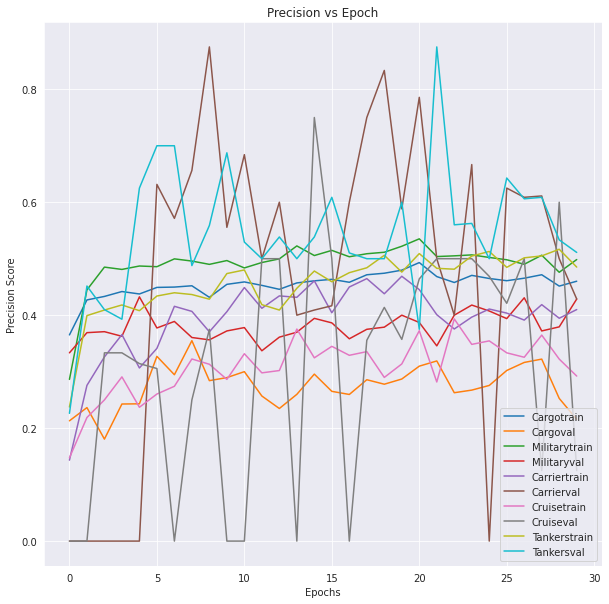

In [21]:
for j in range(5):
    sns.lineplot(x=range(len(results[0])),y=[results[0][i][0][j] for i in range(len(results[0]))])
    sns.lineplot(x=range(len(results[1])),y=[results[1][i][0][j] for i in range(len(results[1]))])


plt.legend(loc='lower right', labels=legend)
plt.title("Precision vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Precision Score')


plt.show()

#### 8.Plotting Kappa vs Epoch<a class="anchor" id="5.8"></a>

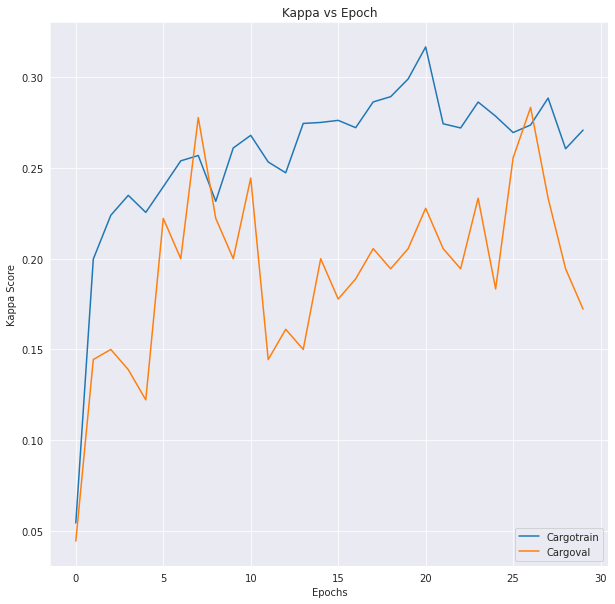

In [22]:

sns.lineplot(x=range(len(kappa[0])),y=kappa[0])
sns.lineplot(x=range(len(kappa[1])),y=kappa[1])


plt.legend(loc='lower right', labels=legend)
plt.title("Kappa vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Kappa Score')


plt.show()

### 6.Testing <a class="anchor" id="6"></a>

In [23]:
class TestDataset(Dataset):
    def __init__(self,x,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        img = Image.open(self.x[i]).convert('RGB')
        return torch.FloatTensor(np.asarray(self.transform(img)))
    


test_dataset = TestDataset(test_img,transform =transforms_test)
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = False )

predictions = []
with torch.no_grad():
    model.eval()
    for _batch_idx_ , x in enumerate(test_dataloader):
        x = x.to(device)
        y_pred = model(x).to(device)
        pred = torch.argmax(y_pred, dim=1)+1
        predictions+=pred.cpu().tolist()

In [24]:
df = pd.DataFrame(list(zip([test_img[i].split('/')[-1] for i in range(len(test_img))], predictions)), index =None, columns =['image', 'category'])
df.to_csv("submission.csv", index=False)
df

,image,category
0,1007700.jpg,2
1,1011369.jpg,1
2,1051155.jpg,2
3,1062001.jpg,2
4,1069397.jpg,2
...,...,...
2675,950995.jpg,2
2676,951046.jpg,1
2677,951323.jpg,1
2678,952113.jpg,2
